# ATE2: DISEÑO DE LEVAS
## Plataforma Levanta Cajas

**Mecanismos - 2025-2**

Prescripción de movimiento:
1. Elevar 50 mm en 1.2s (cicloidal)
2. Reposo 0.3s
3. Descender 25mm (armónico) en 0.9s
4. Reposo 0.6s
5. Descender 25mm (armónico) en 0.9s

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.grid'] = True

## Parámetros

In [2]:
# Tiempos [s]
T1 = 1.2   # subida
T2 = 0.3   # reposo
T3 = 0.9   # bajada 1
T4 = 0.6   # reposo
T5 = 0.9   # bajada 2

# Desplazamientos [mm]
H1 = 50.0
H3 = 25.0
H5 = 25.0

# Rodillo y restricciones
Rf = 20.0          # radio rodillo [mm]
alpha_max = 20.0   # angulo presion max [°]

# Discretizacion
N_puntos = 200

print(f"Tiempos: T1={T1}, T2={T2}, T3={T3}, T4={T4}, T5={T5}")
print(f"Rf={Rf} mm, alpha_max={alpha_max}°")

Tiempos: T1=1.2, T2=0.3, T3=0.9, T4=0.6, T5=0.9
Rf=20.0 mm, alpha_max=20.0°


## Cálculos preliminares

In [3]:
T_total = T1 + T2 + T3 + T4 + T5
print(f"T_total = {T_total} s")

# Velocidad angular
omega_rad = 2*np.pi / T_total
omega_deg = 360.0 / T_total
print(f"omega = {omega_rad:.4f} rad/s = {omega_deg:.4f} °/s")
print(f"RPM = {omega_deg/6:.4f}")

# Angulos beta para cada intervalo
beta1 = omega_deg * T1
beta2 = omega_deg * T2
beta3 = omega_deg * T3
beta4 = omega_deg * T4
beta5 = omega_deg * T5

print(f"\nbeta1={beta1:.2f}°, beta2={beta2:.2f}°, beta3={beta3:.2f}°")
print(f"beta4={beta4:.2f}°, beta5={beta5:.2f}°")
print(f"Suma = {beta1+beta2+beta3+beta4+beta5:.2f}°")

# Limites de tiempo
t_end1 = T1
t_end2 = T1 + T2
t_end3 = T1 + T2 + T3
t_end4 = T1 + T2 + T3 + T4

T_total = 3.9 s
omega = 1.6111 rad/s = 92.3077 °/s
RPM = 15.3846

beta1=110.77°, beta2=27.69°, beta3=83.08°
beta4=55.38°, beta5=83.08°
Suma = 360.00°


## Funciones de movimiento

In [4]:
def cicloidal_subida(t_local, T, H, H0=0):
    # Ecuaciones del libro para rise cicloidal
    ratio = t_local / T
    pos = H0 + H * (ratio - (1/(2*np.pi)) * np.sin(2*np.pi*ratio))
    vel = (H / T) * (1 - np.cos(2*np.pi*ratio))
    acc = (2*np.pi*H / T**2) * np.sin(2*np.pi*ratio)
    return pos, vel, acc

def armonico_bajada(t_local, T, H, H_F):
    # Ecuaciones para fall armonico
    ratio = t_local / T
    pos = H_F - (H/2) * (1 - np.cos(np.pi*ratio))
    vel = -(np.pi*H / (2*T)) * np.sin(np.pi*ratio)
    acc = -(np.pi**2 * H / (2*T**2)) * np.cos(np.pi*ratio)
    return pos, vel, acc

def reposo(H0):
    return H0, 0.0, 0.0

## Generar datos cinemáticos

In [5]:
t_global = np.linspace(0, T_total, N_puntos)

desplazamiento = np.zeros(N_puntos)
velocidad = np.zeros(N_puntos)
aceleracion = np.zeros(N_puntos)
angulo_leva = np.zeros(N_puntos)

for i, t in enumerate(t_global):
    angulo_leva[i] = omega_deg * t
    
    if t <= t_end1:
        # Subida cicloidal
        pos, vel, acc = cicloidal_subida(t, T1, H1, 0)
    elif t <= t_end2:
        # Reposo arriba
        pos, vel, acc = reposo(H1)
    elif t <= t_end3:
        # Bajada 1
        t_local = t - t_end2
        pos, vel, acc = armonico_bajada(t_local, T3, H3, H1)
    elif t <= t_end4:
        # Reposo medio
        pos, vel, acc = reposo(H1 - H3)
    else:
        # Bajada 2
        t_local = t - t_end4
        pos, vel, acc = armonico_bajada(t_local, T5, H5, H1 - H3)
    
    desplazamiento[i] = pos
    velocidad[i] = vel
    aceleracion[i] = acc

print(f"Puntos calculados: {N_puntos}")
print(f"Desplazamiento max: {np.max(desplazamiento):.2f} mm")
print(f"Velocidad max: {np.max(velocidad):.2f} mm/s")
print(f"Aceleracion max: {np.max(np.abs(aceleracion)):.2f} mm/s²")

Puntos calculados: 200
Desplazamiento max: 50.00 mm
Velocidad max: 83.30 mm/s
Aceleracion max: 218.16 mm/s²


## Tabla de datos

In [6]:
df_cinematica = pd.DataFrame({
    'Tiempo [s]': t_global,
    'Angulo [°]': angulo_leva,
    'Desplazamiento [mm]': desplazamiento,
    'Velocidad [mm/s]': velocidad,
    'Aceleracion [mm/s²]': aceleracion
})

print(f"Total de puntos: {len(df_cinematica)}")
df_cinematica.head(15)

Total de puntos: 200


,Tiempo [s],Angulo [°],Desplazamiento [mm],Velocidad [mm/s],Aceleracion [mm/s²]
0,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.019598,1.809045,0.001432,0.219178,22.347816
2,0.039196,3.618090,0.011440,0.874408,44.460521
3,0.058794,5.427136,0.038510,1.958795,66.105476
4,0.078392,7.236181,0.090947,3.460932,87.054963
5,0.097990,9.045226,0.176791,5.365015,107.088583
6,0.117588,10.854271,0.303730,7.651012,125.995570
7,0.137186,12.663317,0.479019,10.294872,143.577012
8,0.156784,14.472362,0.709405,13.268782,159.647943
9,0.176382,16.281407,1.001054,16.541454,174.039286


In [7]:
# Guardar excel
try:
    df_cinematica.to_excel('cinematica_leva.xlsx', index=False)
    print("Guardado: cinematica_leva.xlsx")
except Exception as e:
    print(f"Error guardando excel: {e}")
    # alternativa csv
    df_cinematica.to_csv('cinematica_leva.csv', index=False)
    print("Guardado como CSV en su lugar")

Guardado: cinematica_leva.xlsx


## Gráficas cinemática vs tiempo

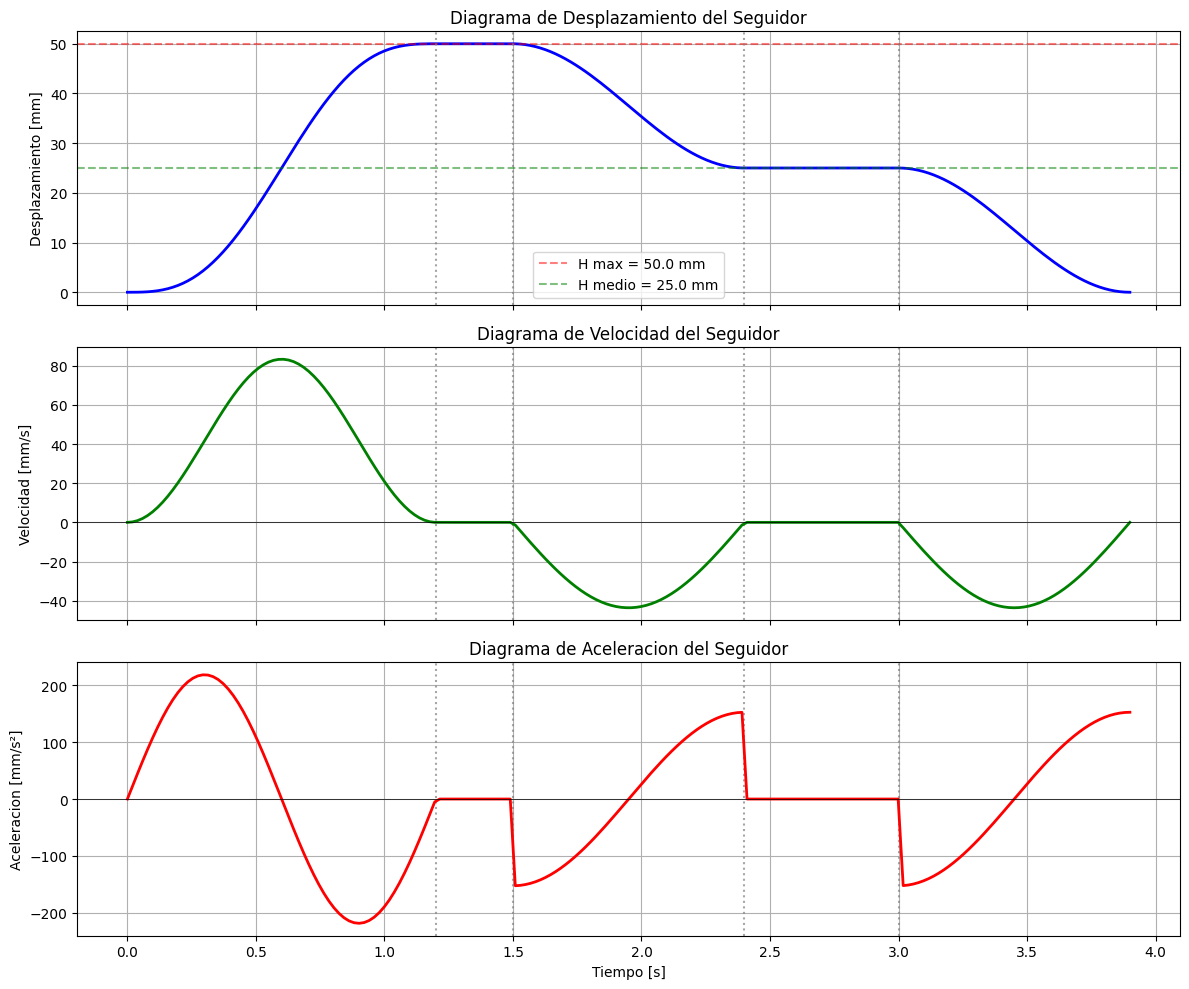

Guardado: cinematica_vs_tiempo.png


In [8]:
fig1, axes = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# Desplazamiento
axes[0].plot(t_global, desplazamiento, 'b-', linewidth=2)
axes[0].set_ylabel('Desplazamiento [mm]')
axes[0].set_title('Diagrama de Desplazamiento del Seguidor')
axes[0].axhline(y=H1, color='r', linestyle='--', alpha=0.5, label=f'H max = {H1} mm')
axes[0].axhline(y=H1-H3, color='g', linestyle='--', alpha=0.5, label=f'H medio = {H1-H3} mm')
axes[0].legend()

# lineas de transicion
for t_lim in [t_end1, t_end2, t_end3, t_end4]:
    axes[0].axvline(x=t_lim, color='gray', linestyle=':', alpha=0.7)
    axes[1].axvline(x=t_lim, color='gray', linestyle=':', alpha=0.7)
    axes[2].axvline(x=t_lim, color='gray', linestyle=':', alpha=0.7)

# Velocidad
axes[1].plot(t_global, velocidad, 'g-', linewidth=2)
axes[1].set_ylabel('Velocidad [mm/s]')
axes[1].set_title('Diagrama de Velocidad del Seguidor')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

# Aceleracion
axes[2].plot(t_global, aceleracion, 'r-', linewidth=2)
axes[2].set_xlabel('Tiempo [s]')
axes[2].set_ylabel('Aceleracion [mm/s²]')
axes[2].set_title('Diagrama de Aceleracion del Seguidor')
axes[2].axhline(y=0, color='k', linestyle='-', linewidth=0.5)

plt.tight_layout()
plt.savefig('cinematica_vs_tiempo.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: cinematica_vs_tiempo.png")

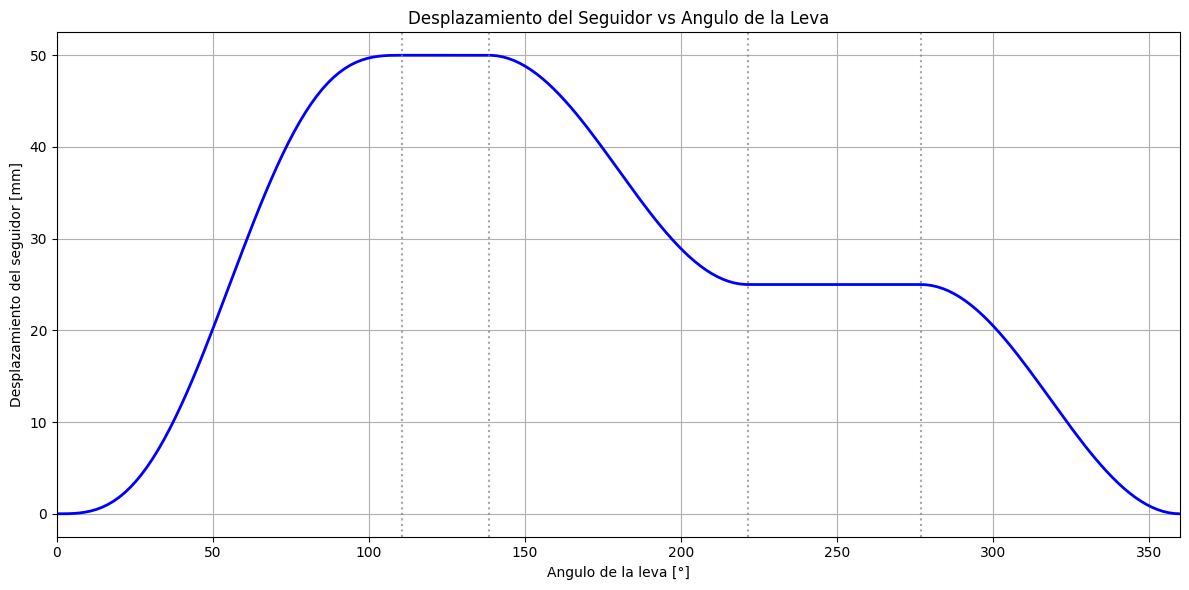

Guardado: desplazamiento_vs_angulo.png


In [9]:
# Desplazamiento vs angulo
fig2, ax = plt.subplots(figsize=(12, 6))
ax.plot(angulo_leva, desplazamiento, 'b-', linewidth=2)
ax.set_xlabel('Angulo de la leva [°]')
ax.set_ylabel('Desplazamiento del seguidor [mm]')
ax.set_title('Desplazamiento del Seguidor vs Angulo de la Leva')
ax.set_xlim([0, 360])

# marcar intervalos
for ang in [beta1, beta1+beta2, beta1+beta2+beta3, beta1+beta2+beta3+beta4]:
    ax.axvline(x=ang, color='gray', linestyle=':', alpha=0.7)

plt.tight_layout()
plt.savefig('desplazamiento_vs_angulo.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: desplazamiento_vs_angulo.png")

---
# PUNTO 2: Perfil de la Leva

## Funciones para el perfil

In [10]:
def calcular_perfil(Rb, Rf, angulo_rad, desp, vel, omega):
    """
    Calcula coordenadas del perfil y angulo de presion
    segun ecuaciones del libro para seguidor de rodillo alineado
    """
    n = len(angulo_rad)
    Rx = np.zeros(n)
    Ry = np.zeros(n)
    alpha = np.zeros(n)
    
    for i in range(n):
        phi = angulo_rad[i]
        dR = desp[i]
        v = vel[i]
        
        R_pitch = Rb + Rf + dR
        
        # angulo de presion
        if R_pitch > 0:
            alpha_rad = np.arctan(v / (omega * R_pitch))
        else:
            alpha_rad = 0
        
        alpha[i] = np.degrees(alpha_rad)
        
        # coordenadas del perfil (leva gira antihorario)
        Rx[i] = -R_pitch * np.sin(phi) + Rf * np.sin(phi - alpha_rad)
        Ry[i] = R_pitch * np.cos(phi) - Rf * np.cos(phi - alpha_rad)
    
    return Rx, Ry, alpha


def buscar_Rb_optimo(Rf, angulo_deg, desp, vel, omega, alpha_limite):
    """
    Busca el Rb minimo que cumple con alpha <= alpha_limite
    """
    angulo_rad = np.radians(angulo_deg)
    iteraciones = []
    
    for Rb_test in range(30, 200, 5):
        Rx, Ry, alpha = calcular_perfil(Rb_test, Rf, angulo_rad, desp, vel, omega)
        alpha_max_calc = np.max(np.abs(alpha))
        
        cumple = alpha_max_calc <= alpha_limite
        iteraciones.append({'Rb [mm]': Rb_test, 'alpha_max [°]': round(alpha_max_calc, 2), 'Cumple': 'Si' if cumple else 'No'})
        
        if cumple:
            return Rb_test, iteraciones
    
    return 200, iteraciones  # si no encuentra, retorna el maximo

## Buscar radio base optimo

In [11]:
print(f"Buscando Rb optimo para alpha_max <= {alpha_max}°")
print(f"Rf = {Rf} mm\n")

Rb_optimo, iteraciones = buscar_Rb_optimo(Rf, angulo_leva, desplazamiento, velocidad, omega_rad, alpha_max)

df_iter = pd.DataFrame(iteraciones)
print("Iteraciones:")
print(df_iter.to_string(index=False))
print(f"\n>>> Rb optimo = {Rb_optimo} mm")

Buscando Rb optimo para alpha_max <= 20.0°
Rf = 20.0 mm

Iteraciones:
 Rb [mm]  alpha_max [°] Cumple
      30          35.87     No
      35          33.97     No
      40          32.26     No
      45          30.70     No
      50          29.27     No
      55          27.95     No
      60          26.76     No
      65          25.66     No
      70          24.64     No
      75          23.69     No
      80          22.82     No
      85          22.00     No
      90          21.23     No
      95          20.52     No
     100          19.84     Si

>>> Rb optimo = 100 mm


## Calcular perfil con Rb optimo

In [12]:
angulo_leva_rad = np.radians(angulo_leva)
Rx, Ry, alpha = calcular_perfil(Rb_optimo, Rf, angulo_leva_rad, desplazamiento, velocidad, omega_rad)

print(f"Alpha max = {np.max(np.abs(alpha)):.2f}°")
print(f"Alpha min = {np.min(alpha):.2f}°")

# Dataframe del perfil
df_perfil = pd.DataFrame({
    'Angulo [°]': angulo_leva,
    'dR [mm]': desplazamiento,
    'v [mm/s]': velocidad,
    'alpha [°]': alpha,
    'Rx [mm]': Rx,
    'Ry [mm]': Ry
})

df_perfil.head(10)

Alpha max = 19.84°
Alpha min = -11.60°


,Angulo [°],dR [mm],v [mm/s],alpha [°],Rx [mm],Ry [mm]
0,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000
1,1.809045,0.001432,0.219178,0.064956,-3.179563,99.950888
2,3.618090,0.011440,0.874408,0.259117,-6.401566,99.806599
3,5.427136,0.038510,1.958795,0.580311,-9.663375,99.571929
4,7.236181,0.090947,3.460932,1.024811,-12.962688,99.251876
5,9.045226,0.176791,5.365015,1.587255,-16.297501,98.851532
6,10.854271,0.303730,7.651012,2.260589,-19.666070,98.375957
7,12.663317,0.479019,10.294872,3.036059,-23.066844,97.830047
8,14.472362,0.709405,13.268782,3.903236,-26.498411,97.218404
9,16.281407,1.001054,16.541454,4.850124,-29.959428,96.545205


In [13]:
# Guardar perfil
try:
    df_perfil.to_excel('perfil_leva.xlsx', index=False)
    print("Guardado: perfil_leva.xlsx")
except:
    df_perfil.to_csv('perfil_leva.csv', index=False)
    print("Guardado como CSV")

Guardado: perfil_leva.xlsx


## Grafica del perfil

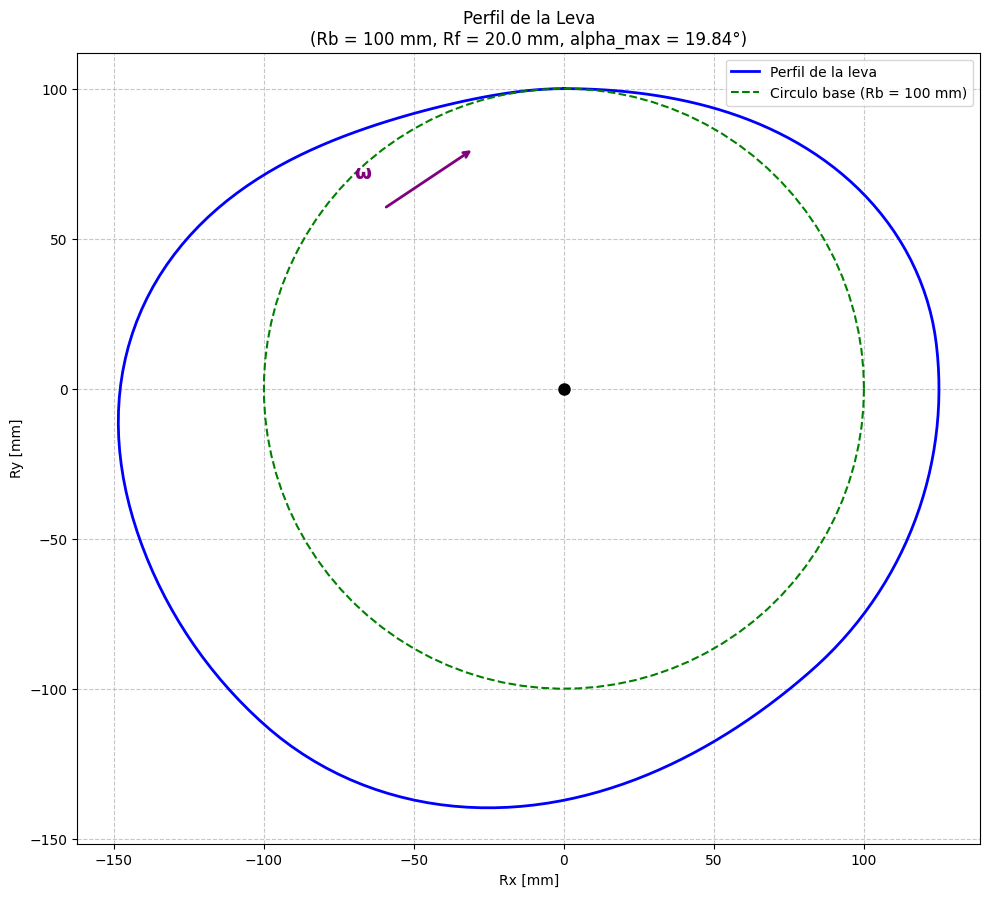

Guardado: perfil_leva.png


In [14]:
fig3, ax = plt.subplots(figsize=(10, 10))

# Perfil
ax.plot(Rx, Ry, 'b-', linewidth=2, label='Perfil de la leva')

# Circulo base
theta = np.linspace(0, 2*np.pi, 100)
ax.plot(Rb_optimo*np.cos(theta), Rb_optimo*np.sin(theta), 'g--', linewidth=1.5, label=f'Circulo base (Rb = {Rb_optimo} mm)')

# Centro
ax.plot(0, 0, 'ko', markersize=8)

ax.set_xlabel('Rx [mm]')
ax.set_ylabel('Ry [mm]')
ax.set_title(f'Perfil de la Leva\n(Rb = {Rb_optimo} mm, Rf = {Rf} mm, alpha_max = {np.max(np.abs(alpha)):.2f}°)')
ax.set_aspect('equal')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

# Flecha rotacion
ax.annotate('', xy=(-30, 80), xytext=(-60, 60), arrowprops=dict(arrowstyle='->', color='purple', lw=2))
ax.text(-70, 70, 'ω', fontsize=14, color='purple', fontweight='bold')

plt.tight_layout()
plt.savefig('perfil_leva.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: perfil_leva.png")

## Grafica angulo de presion

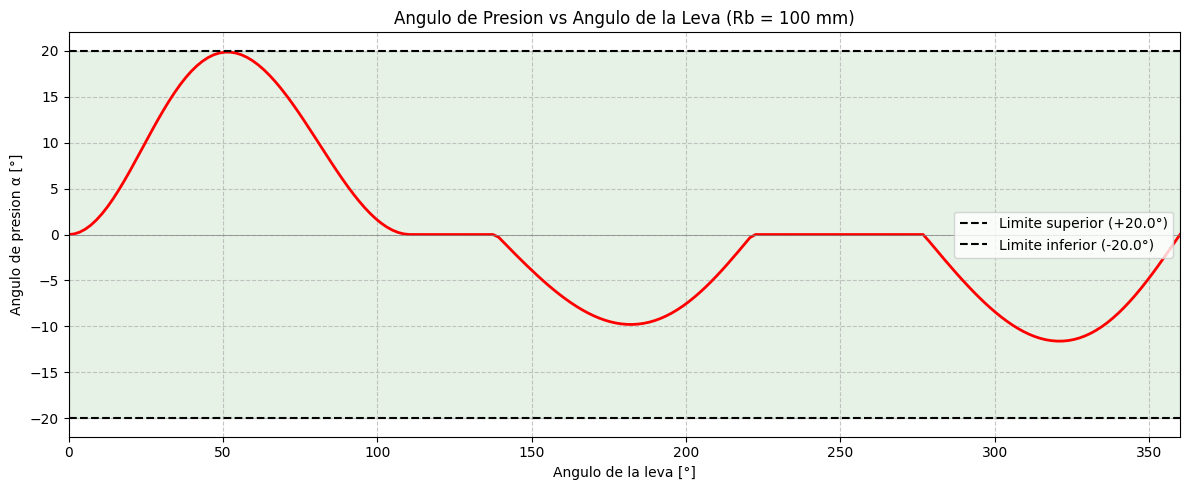

Guardado: angulo_presion.png


In [15]:
fig4, ax = plt.subplots(figsize=(12, 5))

ax.plot(angulo_leva, alpha, 'r-', linewidth=2)
ax.axhline(y=alpha_max, color='k', linestyle='--', label=f'Limite superior (+{alpha_max}°)')
ax.axhline(y=-alpha_max, color='k', linestyle='--', label=f'Limite inferior (-{alpha_max}°)')
ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.fill_between(angulo_leva, -alpha_max, alpha_max, alpha=0.1, color='green')

ax.set_xlabel('Angulo de la leva [°]')
ax.set_ylabel('Angulo de presion α [°]')
ax.set_title(f'Angulo de Presion vs Angulo de la Leva (Rb = {Rb_optimo} mm)')
ax.set_xlim([0, 360])
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('angulo_presion.png', dpi=150, bbox_inches='tight')
plt.show()
print("Guardado: angulo_presion.png")

---
## Resumen

In [16]:
print("="*50)
print("RESUMEN DEL DISEÑO")
print("="*50)
print(f"""  
Parametros de entrada:
  Elevacion: {H1} mm (cicloidal)
  Descenso 1: {H3} mm (armonico)
  Descenso 2: {H5} mm (armonico)
  Rf = {Rf} mm
  alpha_max permitido = {alpha_max}°

Tiempos:
  T1={T1}s, T2={T2}s, T3={T3}s, T4={T4}s, T5={T5}s
  Total = {T_total}s

Angulos beta:
  b1={beta1:.2f}°, b2={beta2:.2f}°, b3={beta3:.2f}°
  b4={beta4:.2f}°, b5={beta5:.2f}°

Velocidad angular:
  omega = {omega_deg:.4f} °/s = {omega_rad:.4f} rad/s
  RPM = {omega_deg/6:.4f}

Resultados:
  Rb optimo = {Rb_optimo} mm
  alpha_max calculado = {np.max(np.abs(alpha)):.2f}°
  v_max = {np.max(velocidad):.2f} mm/s
  a_max = {np.max(np.abs(aceleracion)):.2f} mm/s²
  
Puntos de discretizacion: {N_puntos}
""")

RESUMEN DEL DISEÑO
  
Parametros de entrada:
  Elevacion: 50.0 mm (cicloidal)
  Descenso 1: 25.0 mm (armonico)
  Descenso 2: 25.0 mm (armonico)
  Rf = 20.0 mm
  alpha_max permitido = 20.0°

Tiempos:
  T1=1.2s, T2=0.3s, T3=0.9s, T4=0.6s, T5=0.9s
  Total = 3.9s

Angulos beta:
  b1=110.77°, b2=27.69°, b3=83.08°
  b4=55.38°, b5=83.08°

Velocidad angular:
  omega = 92.3077 °/s = 1.6111 rad/s
  RPM = 15.3846

Resultados:
  Rb optimo = 100 mm
  alpha_max calculado = 19.84°
  v_max = 83.30 mm/s
  a_max = 218.16 mm/s²
  
Puntos de discretizacion: 200



In [17]:
# Tabla resumen
resumen = {
    'Parametro': ['T_total', 'omega [°/s]', 'omega [rad/s]', 'RPM', 
                  'beta1', 'beta2', 'beta3', 'beta4', 'beta5',
                  'Rf', 'Rb_optimo', 'alpha_max', 'v_max', 'a_max', 'N_puntos'],
    'Valor': [T_total, round(omega_deg,4), round(omega_rad,4), round(omega_deg/6,4),
              round(beta1,2), round(beta2,2), round(beta3,2), round(beta4,2), round(beta5,2),
              Rf, Rb_optimo, round(np.max(np.abs(alpha)),2),
              round(np.max(velocidad),2), round(np.max(np.abs(aceleracion)),2), N_puntos],
    'Unidad': ['s', '°/s', 'rad/s', 'rpm', '°', '°', '°', '°', '°', 'mm', 'mm', '°', 'mm/s', 'mm/s²', 'puntos']
}
df_resumen = pd.DataFrame(resumen)

try:
    df_resumen.to_excel('resumen_parametros.xlsx', index=False)
    print("Guardado: resumen_parametros.xlsx")
except:
    df_resumen.to_csv('resumen_parametros.csv', index=False)
    print("Guardado como CSV")

df_resumen

Guardado: resumen_parametros.xlsx


,Parametro,Valor,Unidad
0,T_total,3.9000,s
1,omega [°/s],92.3077,°/s
2,omega [rad/s],1.6111,rad/s
3,RPM,15.3846,rpm
4,beta1,110.7700,°
5,beta2,27.6900,°
6,beta3,83.0800,°
7,beta4,55.3800,°
8,beta5,83.0800,°
9,Rf,20.0000,mm
